In [22]:
import math
from scipy.stats import multivariate_normal as mv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style('oceans16')

%matplotlib inline

In [4]:
prior_std = 10 # hyperparameter

# true parameters
K = 3
mu = []
for i in range(K):
    mu.append(np.random.normal(0, prior_std))

var = 1
var_arr = [1, 1, 1]
print(mu)

[6.878471842374035, 8.143905526598505, -5.483030302022521]


In [5]:
color = ['blue', 'green', 'red', 'magent', 'yellow']

In [6]:
n = 1000
mixture_selection_matrix = np.identity(K)
N = np.random.choice(K,n)
N.shape

(1000,)

In [7]:
from collections import defaultdict
data = []
data_resp = defaultdict(list)
plt.figure(1)
for i in range(n):
    mean = np.dot(mixture_selection_matrix[N[i]], mu)
    cov = np.dot(mixture_selection_matrix[N[i]], var_arr)*var
    x = np.random.normal(mean, cov)
    data.append(x)
    data_resp[N[i]].append(x)

<Figure size 432x288 with 0 Axes>

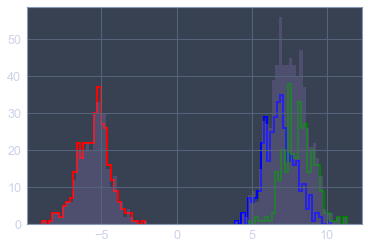

In [23]:
for k in range(K):
    plt.hist(data_resp[k], bins=30, color=color[k], histtype='step', lw=2);
plt.hist(data, color='m', bins=90, alpha=0.3);

In [51]:
def VI(K, prior_std, n, data):
    # Initialization
    mu_mean = []
    mu_var = []
    for i in range(K):
        mu_mean.append(np.random.normal(0, prior_std))
        mu_var.append(abs(np.random.normal(0, prior_std)))
    
    c_est = np.zeros((n, K))
    for i in range(n):
        c_est[i, np.random.choice(K)] = 1
        
    # Initiate CAVI iterations
    while(True):
        mu_mean_old = mu_mean[:]
        
        # mixture model parameter update step
        for j in range(K):
            nr = 0
            dr = 0
            for i in range(n):
                nr += c_est[i, j]*data[i]
                dr += c_est[i, j]
            mu_mean[j] = nr/((1/prior_std**2) + dr)
            mu_var[j] = 1.0/((1/prior_std**2) + dr)


        # categorical vector update step
        for i in range(n):
            cat_vec = []
            for j in range(K):
                cat_vec.append(math.exp(mu_mean[j]*data[i] - (mu_var[j] + mu_mean[j]**2)/2))
            for k in range(K):
                c_est[i, k] = cat_vec[k]/np.sum(np.array(cat_vec))
                
        # compute ELBO or check for convergence of variational factors - here we do the latter
        if np.dot(np.array(mu_mean_old) - np.array(mu_mean), np.array(mu_mean_old) - np.array(mu_mean)) < 0.00001:
            break

    # sort the values since the k mixture components dont maintain any ordering across multiple initializations
    mixture_components = list(zip(mu_mean, mu_var))
    mixture_components.sort()
    return mixture_components, c_est

In [52]:
mixture_components, c_est = VI(K, prior_std, n, data)

3 || [(-5.490802029421355, 0.003086324496157526), (6.773119513537158, 0.0029461885635759595), (8.13721067964549, 0.0029708993374482394)] || [[1.00000000e+00 4.79247441e-36 5.19165952e-44]
 [1.25813658e-41 2.62801299e-01 7.37198701e-01]
 [5.94044345e-43 2.06790706e-01 7.93209294e-01]
 ...
 [2.00704049e-28 9.01397358e-01 9.86026423e-02]
 [4.63355712e-47 9.07242117e-02 9.09275788e-01]
 [9.81954300e-38 4.74921556e-01 5.25078444e-01]]


C:\Users\ares\Anaconda3\envs\py35\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


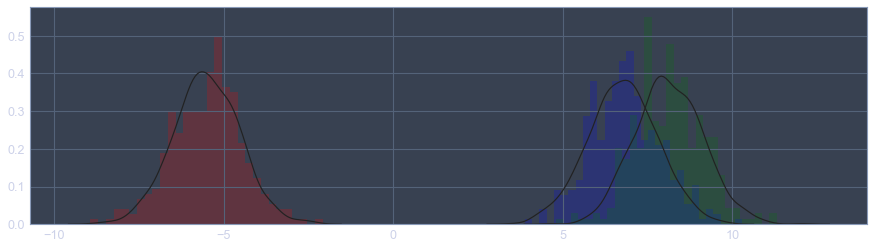

In [53]:
print(K,"||",mixture_components, "||", c_est)
plt.figure(figsize=(15,4))
for k in range(K):
    plt.hist(data_resp[k], bins=30, color=color[k], alpha=0.2, normed=True);
for k in range(K):
    vals=np.random.normal(mixture_components[k][0], 1, size=1000)
    sns.kdeplot(vals,  color='k');

C:\Users\ares\Anaconda3\envs\py35\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


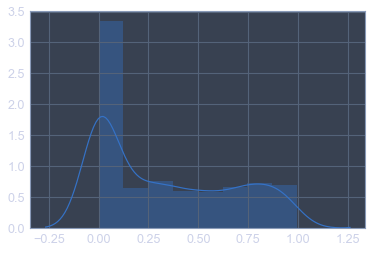

In [41]:
sns.distplot(c_est[:,0])